## Disease Prediction in Python

### This set of code uses numpy, pandas, matplotlib, seaborn, pickle, and sklearn for determining the most accurate disease based on the set of 17 symptoms. Additionally, another data set includes the symptoms with a weight ranking variable (values 1-7) for each symptom. First we explore using random forest based on just the symptoms and predicting disease. The prediction is further refined by incorporating the symptom weights for the disease prediction. Since a few of the symptoms (read below for further details) did not have a weight value in the data set provided, the values were imputed based on some exploratory analysis of the distribution of weight rankings as well as the distribution of symptoms for that corresponding disease. A confusion matrix was created, and determined a disease match accuracy of ~98.0%-99.5%. A random forest was used for this new addition of weight rankings, and the accuracy was ~99%. After loading the model into pickle and test running, the model maintained ~99% accuracy in determining the disease based on symptoms and symptom weight. 

### Citation
### This data set was obtained from https://www.kaggle.com/datasets/itachi9604/disease-symptom-description-dataset on 5/12/2023 under the following license: https://creativecommons.org/licenses/by-sa/4.0/ as listed on the author's page. No additional authorship or citation information was provided. This license allows the user to share and adapt the material as long as appropriate credit is given, and changes need to be acknowledged. There were no changes to this material, and this is for educational purposes only. 

In [2]:
#Import libraries

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Import source data files
# File to Load - main disease and symptoms data set and symptom severity ranking data set.
file_to_load = "Data/dataset.csv" #Disease and symptoms data set
file_to_load2 = "Data/Symptom-severity.csv" #Symptom severity weights/ranking data set

# Read datasets and store into Pandas data frame
df = pd.read_csv(file_to_load)
df_sev=pd.read_csv(file_to_load2)

In [4]:
#Check contents of main disease and symptoms data set
df.head()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
0,Fungal infection,itching,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Fungal infection,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Fungal infection,itching,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Fungal infection,itching,skin_rash,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Fungal infection,itching,skin_rash,nodal_skin_eruptions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


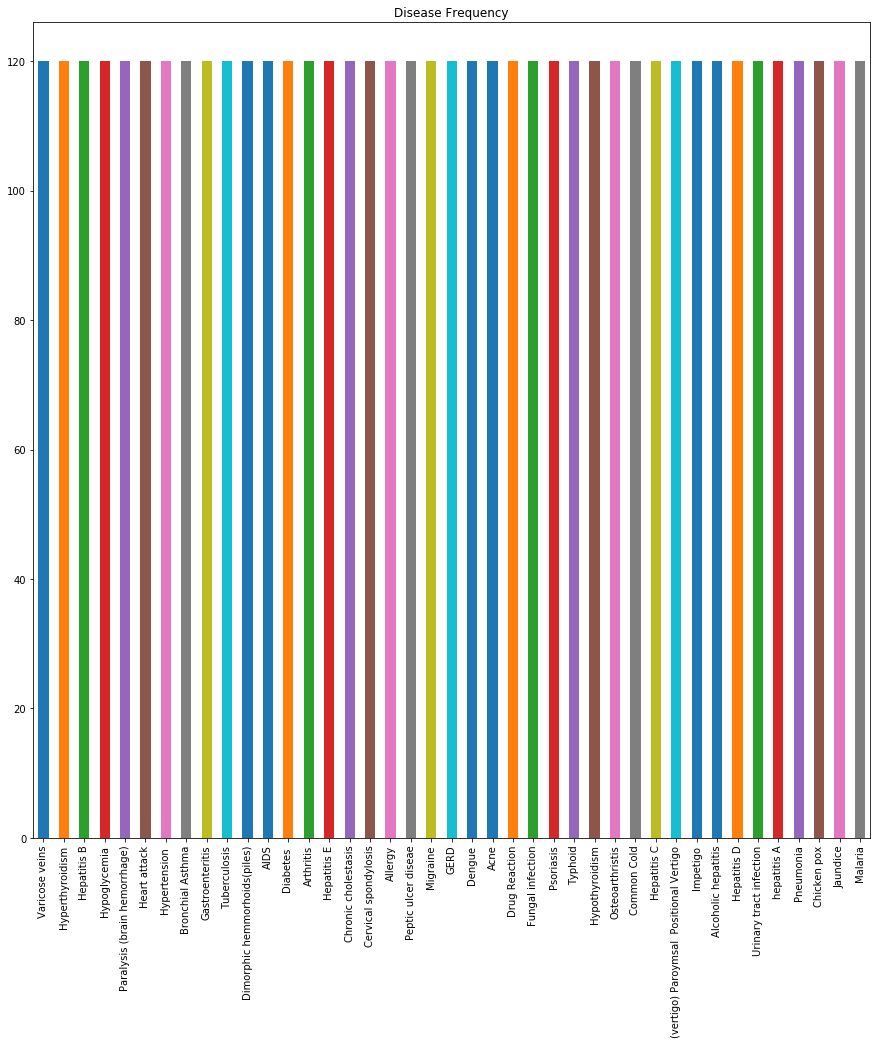

In [5]:
#Check the frequency of diseases - it looks like they all appear equally in the data set.
df_plot1 = df
df_plot1 = df_plot1.Disease.value_counts().plot(kind='bar', title='Disease Frequency', figsize=(15,15))
df_plot1.set_xlabel=('Disease')
df_plot1.set_ylabel=('Count')

In [6]:
#Check contents symptom severity data set
df_sev.head()

,Symptom,weight
0,itching,1
1,skin_rash,3
2,nodal_skin_eruptions,4
3,continuous_sneezing,4
4,shivering,5


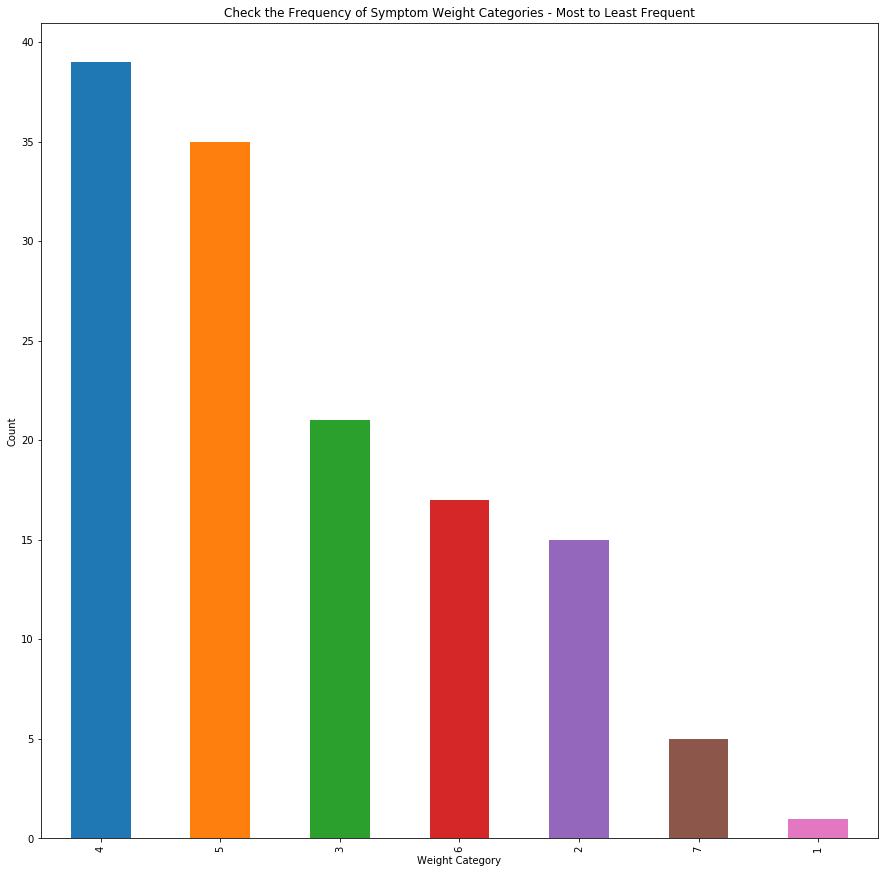

In [7]:
#Check the frequency of weight values
#The most common seems to be 4.

df_plot2 = df_sev
df_plot2 = df_plot2['weight'].value_counts().plot(kind='bar', title='Check the Frequency of Symptom Weight Categories - Most to Least Frequent', figsize=(15,15))
df_plot2.set_xlabel("Weight Category")
df_plot2.set_ylabel("Count")

plt.savefig('Symptom Weight Category Frequencies.png')

## Perform Random forest with just the symptoms/diseases data set and see results for disease prediction.

In [8]:
#Collect each symptom for every record and store in a list as "Symptom". Currently, all symptoms are spread into
#individual symptom variables- this will combine them.

df["Symptom"] = 0

symptom_types = df.shape[0]
for i in range(symptom_types):
    values = df.iloc[i].values
    values = values.tolist()
    if 0 in values:
        df["Symptom"][i] = values[1:values.index(0)]
    else:
        df["Symptom"][i] = values[1:]
        
#Show all the symptom values are concatenated in a list.
df["Symptom"].head()

0    [itching,  skin_rash,  nodal_skin_eruptions,  ...
1    [ skin_rash,  nodal_skin_eruptions,  dischromi...
2    [itching,  nodal_skin_eruptions,  dischromic _...
3    [itching,  skin_rash,  dischromic _patches, na...
4    [itching,  skin_rash,  nodal_skin_eruptions, n...
Name: Symptom, dtype: object

In [9]:
df.head()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17,Symptom
0,Fungal infection,itching,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[itching, skin_rash, nodal_skin_eruptions, ..."
1,Fungal infection,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[ skin_rash, nodal_skin_eruptions, dischromi..."
2,Fungal infection,itching,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[itching, nodal_skin_eruptions, dischromic _..."
3,Fungal infection,itching,skin_rash,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[itching, skin_rash, dischromic _patches, na..."
4,Fungal infection,itching,skin_rash,nodal_skin_eruptions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[itching, skin_rash, nodal_skin_eruptions, n..."


In [10]:
column_values = df.iloc[:, 1:18].values.ravel()
dis_sym = pd.Series(column_values).dropna().unique().tolist()
all_dis_syms = pd.DataFrame(columns=dis_sym).reindex(index=df.index)

#Print a few records.
all_dis_syms.head(10)

,itching,skin_rash,nodal_skin_eruptions,dischromic _patches,continuous_sneezing,shivering,chills,watering_from_eyes,stomach_pain,acidity,...,bladder_discomfort,foul_smell_of urine,continuous_feel_of_urine,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
#Attach new dummy variables to original data frame.
all_dis_syms["Symptom"] = df["Symptom"]

all_dis_syms.head()

,itching,skin_rash,nodal_skin_eruptions,dischromic _patches,continuous_sneezing,shivering,chills,watering_from_eyes,stomach_pain,acidity,...,foul_smell_of urine,continuous_feel_of_urine,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,Symptom
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[itching, skin_rash, nodal_skin_eruptions, ..."
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[ skin_rash, nodal_skin_eruptions, dischromi..."
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[itching, nodal_skin_eruptions, dischromic _..."
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[itching, skin_rash, dischromic _patches, na..."
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[itching, skin_rash, nodal_skin_eruptions, n..."


In [12]:
#Loop through each disease symptom and assign 1 if the record has that symptom listed and 0 if not.
#Keep Disease variable.

for i in dis_sym:
    all_dis_syms[i] = all_dis_syms.apply(lambda x:1 if i in x.Symptom else 0, axis=1)

In [13]:
all_dis_syms["Disease"] = df["Disease"]
all_dis_syms = all_dis_syms.drop("Symptom",axis=1)

In [14]:
all_dis_syms.head()

,itching,skin_rash,nodal_skin_eruptions,dischromic _patches,continuous_sneezing,shivering,chills,watering_from_eyes,stomach_pain,acidity,...,foul_smell_of urine,continuous_feel_of_urine,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,Disease
0,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
1,0,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
2,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
3,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection


In [15]:
#Exploratory analysis of symptoms only
#Drop disease variable
all_dis_syms_mod = all_dis_syms.drop(columns='Disease')
all_dis_syms_mod.head()

,itching,skin_rash,nodal_skin_eruptions,dischromic _patches,continuous_sneezing,shivering,chills,watering_from_eyes,stomach_pain,acidity,...,bladder_discomfort,foul_smell_of urine,continuous_feel_of_urine,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze
0,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
all_dis_syms_mod.describe()

,itching,skin_rash,nodal_skin_eruptions,dischromic _patches,continuous_sneezing,shivering,chills,watering_from_eyes,stomach_pain,acidity,...,bladder_discomfort,foul_smell_of urine,continuous_feel_of_urine,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze
count,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,...,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000
mean,0.137805,0.159756,0.021951,0.021951,0.045122,0.021951,0.162195,0.021951,0.045122,0.045122,...,0.023171,0.020732,0.023171,0.023171,0.023171,0.023171,0.023171,0.023171,0.023171,0.023171
std,0.344730,0.366417,0.146539,0.146539,0.207593,0.146539,0.368667,0.146539,0.207593,0.207593,...,0.150461,0.142499,0.150461,0.150461,0.150461,0.150461,0.150461,0.150461,0.150461,0.150461
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [17]:
#Random forest for disease prediction
train, test = train_test_split(all_dis_syms,test_size=0.2)
X_train = train.drop("Disease",axis=1)
y_train = train["Disease"].copy()
X_test = test.drop("Disease",axis=1)
y_test = test["Disease"].copy()

rnd_forest = RandomForestClassifier()
rnd_forest.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [18]:
cross_val_score(rnd_forest,X_train,y_train,cv=10).mean()

1.0

In [19]:
y_pred = rnd_forest.predict(X_test)
accuracy_score(y_test,y_pred)

1.0

## There's more to the data such as symptom severity weights. Create a support vector classifier (SVC) and cross-validate with grid search.

In [20]:
#Look at the contents of the symptom severity weights data set.
df_sev.describe

<bound method NDFrame.describe of                             Symptom  weight
0                           itching       1
1                         skin_rash       3
2              nodal_skin_eruptions       4
3               continuous_sneezing       4
4                         shivering       5
5                            chills       3
6                        joint_pain       3
7                      stomach_pain       5
8                           acidity       3
9                  ulcers_on_tongue       4
10                   muscle_wasting       3
11                         vomiting       5
12              burning_micturition       6
13               spotting_urination       6
14                          fatigue       4
15                      weight_gain       3
16                          anxiety       4
17             cold_hands_and_feets       5
18                      mood_swings       3
19                      weight_loss       3
20                     restlessness       

In [21]:
#Need to remove extra spaces in symptom variables to match with severity data set.
df_main = df
cols = df_main.columns

new = df_main.stack().str.strip().unstack()

df_main = pd.DataFrame(new, columns=df_main.columns)
df_main.head()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17,Symptom
0,Fungal infection,itching,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Fungal infection,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Fungal infection,itching,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Fungal infection,itching,skin_rash,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Fungal infection,itching,skin_rash,nodal_skin_eruptions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
#remove NaN; fill with 0 instead.
df_main = df_main.fillna(0)
df_main.head()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17,Symptom
0,Fungal infection,itching,skin_rash,nodal_skin_eruptions,dischromic _patches,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Fungal infection,skin_rash,nodal_skin_eruptions,dischromic _patches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Fungal infection,itching,nodal_skin_eruptions,dischromic _patches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Fungal infection,itching,skin_rash,dischromic _patches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Fungal infection,itching,skin_rash,nodal_skin_eruptions,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [23]:
vals = df_main.values
symptoms = df_sev['Symptom'].unique()

for i in range(len(symptoms)):
    vals[vals == symptoms[i]] = df_sev[df_sev['Symptom'] == symptoms[i]]['weight'].values[0]
    
new2 = pd.DataFrame(vals, columns=cols)
new2.head()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17,Symptom
0,Fungal infection,1,3,4,dischromic _patches,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Fungal infection,3,4,dischromic _patches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Fungal infection,1,4,dischromic _patches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Fungal infection,1,3,dischromic _patches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Fungal infection,1,3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [24]:
#Get a look at all values across symptoms and the disease column
for cols in new2.columns:
    print(new2[cols].value_counts())

Varicose veins                             120
GERD                                       120
Migraine                                   120
Hepatitis B                                120
Hypoglycemia                               120
Diabetes                                   120
Paralysis (brain hemorrhage)               120
Heart attack                               120
Bronchial Asthma                           120
Gastroenteritis                            120
Tuberculosis                               120
Dimorphic hemmorhoids(piles)               120
AIDS                                       120
Arthritis                                  120
Hepatitis E                                120
Chronic cholestasis                        120
Cervical spondylosis                       120
Allergy                                    120
Peptic ulcer diseae                        120
Hyperthyroidism                            120
Acne                                       120
Dengue       

In [25]:
#Three disease symptoms did not have a weight/ranking in the severity data set.
#Instead of doing a simple imputation, we should dive deeper to match with a weight that would make sense for these symptoms.

#Symptoms:
#foul_smell_of urine
#dischromic _patches
#spotting_ urination

In [26]:
for i in range(1, 18):
    symptoms_col = f"Symptom_{i}"
    df_filtered = new2[new2[symptoms_col] == 'foul_smell_of urine']
    df = df_filtered.groupby('Disease').size().reset_index(name='count')
    print(f"Symptom {i} frequencies where value = 'foul_smell_of urine':")
    print(df)

Symptom 1 frequencies where value = 'foul_smell_of urine':
Empty DataFrame
Columns: [Disease, count]
Index: []
Symptom 2 frequencies where value = 'foul_smell_of urine':
                   Disease  count
0  Urinary tract infection     18
Symptom 3 frequencies where value = 'foul_smell_of urine':
                   Disease  count
0  Urinary tract infection     84
Symptom 4 frequencies where value = 'foul_smell_of urine':
Empty DataFrame
Columns: [Disease, count]
Index: []
Symptom 5 frequencies where value = 'foul_smell_of urine':
Empty DataFrame
Columns: [Disease, count]
Index: []
Symptom 6 frequencies where value = 'foul_smell_of urine':
Empty DataFrame
Columns: [Disease, count]
Index: []
Symptom 7 frequencies where value = 'foul_smell_of urine':
Empty DataFrame
Columns: [Disease, count]
Index: []
Symptom 8 frequencies where value = 'foul_smell_of urine':
Empty DataFrame
Columns: [Disease, count]
Index: []
Symptom 9 frequencies where value = 'foul_smell_of urine':
Empty DataFrame
Colum

In [27]:
for i in range(1, 18):
    symptoms_col = f"Symptom_{i}"
    df_filtered = new2[new2[symptoms_col] == 'dischromic _patches']
    df = df_filtered.groupby('Disease').size().reset_index(name='count')
    print(f"Symptom {i} frequencies where value = 'dischromic _patches':")
    print(df)

Symptom 1 frequencies where value = 'dischromic _patches':
Empty DataFrame
Columns: [Disease, count]
Index: []
Symptom 2 frequencies where value = 'dischromic _patches':
Empty DataFrame
Columns: [Disease, count]
Index: []
Symptom 3 frequencies where value = 'dischromic _patches':
            Disease  count
0  Fungal infection     36
Symptom 4 frequencies where value = 'dischromic _patches':
            Disease  count
0  Fungal infection     72
Symptom 5 frequencies where value = 'dischromic _patches':
Empty DataFrame
Columns: [Disease, count]
Index: []
Symptom 6 frequencies where value = 'dischromic _patches':
Empty DataFrame
Columns: [Disease, count]
Index: []
Symptom 7 frequencies where value = 'dischromic _patches':
Empty DataFrame
Columns: [Disease, count]
Index: []
Symptom 8 frequencies where value = 'dischromic _patches':
Empty DataFrame
Columns: [Disease, count]
Index: []
Symptom 9 frequencies where value = 'dischromic _patches':
Empty DataFrame
Columns: [Disease, count]
Index: 

In [28]:
for i in range(1, 18):
    symptoms_col = f"Symptom_{i}"
    df_filtered = new2[new2[symptoms_col] == 'spotting_ urination']
    df = df_filtered.groupby('Disease').size().reset_index(name='count')
    print(f"Symptom {i} frequencies where value = 'spotting_ urination':")
    print(df)

Symptom 1 frequencies where value = 'spotting_ urination':
Empty DataFrame
Columns: [Disease, count]
Index: []
Symptom 2 frequencies where value = 'spotting_ urination':
Empty DataFrame
Columns: [Disease, count]
Index: []
Symptom 3 frequencies where value = 'spotting_ urination':
Empty DataFrame
Columns: [Disease, count]
Index: []
Symptom 4 frequencies where value = 'spotting_ urination':
         Disease  count
0  Drug Reaction     42
Symptom 5 frequencies where value = 'spotting_ urination':
         Disease  count
0  Drug Reaction     66
Symptom 6 frequencies where value = 'spotting_ urination':
Empty DataFrame
Columns: [Disease, count]
Index: []
Symptom 7 frequencies where value = 'spotting_ urination':
Empty DataFrame
Columns: [Disease, count]
Index: []
Symptom 8 frequencies where value = 'spotting_ urination':
Empty DataFrame
Columns: [Disease, count]
Index: []
Symptom 9 frequencies where value = 'spotting_ urination':
Empty DataFrame
Columns: [Disease, count]
Index: []
Symptom 1

In [29]:
#Check the typical rankings for the disease groups
def loop_it(num):
    freq_table = pd.crosstab(new2['Disease'], new2['Symptom_{}'.format(num)])
    print('Frequency table for Symptom_{}:\n'.format(num))
    print(freq_table)

for i in range(1, 18):
    loop_it(i)

Frequency table for Symptom_1:

Symptom_1                                  1    2    3    4    5    6   7
Disease                                                                  
(vertigo) Paroymsal  Positional Vertigo    0    0    6    0  114    0   0
AIDS                                       0    0  108    0    0   12   0
Acne                                       0    6  114    0    0    0   0
Alcoholic hepatitis                        0    0    6    0  114    0   0
Allergy                                    0    0    0  108   12    0   0
Arthritis                                  0  114    0    6    0    0   0
Bronchial Asthma                           0    0    0  120    0    0   0
Cervical spondylosis                       0    0  108    0    0    0  12
Chicken pox                              114    0    6    0    0    0   0
Chronic cholestasis                      114    0    0    0    6    0   0
Common Cold                                0    0    6  114    0    0   0
Dengue

hepatitis A                                                0  
Frequency table for Symptom_4:

Symptom_4                                 0    2    3    4   5   6    7  \
Disease                                                                   
(vertigo) Paroymsal  Positional Vertigo   0    0    0   30   0  90    0   
AIDS                                     42    0    0    0  78   0    0   
Acne                                     42   78    0    0   0   0    0   
Alcoholic hepatitis                       0    0    0   24   0   0   96   
Allergy                                  48    0    0   72   0   0    0   
Arthritis                                 0   24    0    0  96   0    0   
Bronchial Asthma                          0    0    0   84  36   0    0   
Cervical spondylosis                      0    0    0  120   0   0    0   
Chicken pox                               0   96    0    0   0   0   24   
Chronic cholestasis                       0    0    0   24  96   0    0   
Commo

hepatitis A                                                0  
Frequency table for Symptom_6:

Symptom_6                                  0   2   3    4    5   6   7
Disease                                                               
(vertigo) Paroymsal  Positional Vertigo   42   0   0   78    0   0   0
AIDS                                     120   0   0    0    0   0   0
Acne                                     120   0   0    0    0   0   0
Alcoholic hepatitis                        0   0   0    0   84  36   0
Allergy                                  120   0   0    0    0   0   0
Arthritis                                120   0   0    0    0   0   0
Bronchial Asthma                          48   0   0   72    0   0   0
Cervical spondylosis                     120   0   0    0    0   0   0
Chicken pox                                0   0  84   36    0   0   0
Chronic cholestasis                        0   0   0  120    0   0   0
Common Cold                                0   0  84 

Frequency table for Symptom_9:

Symptom_9                                  0    2   3    4    5    6   7
Disease                                                                 
(vertigo) Paroymsal  Positional Vertigo  120    0   0    0    0    0   0
AIDS                                     120    0   0    0    0    0   0
Acne                                     120    0   0    0    0    0   0
Alcoholic hepatitis                      120    0   0    0    0    0   0
Allergy                                  120    0   0    0    0    0   0
Arthritis                                120    0   0    0    0    0   0
Bronchial Asthma                         120    0   0    0    0    0   0
Cervical spondylosis                     120    0   0    0    0    0   0
Chicken pox                                0    0   0    0    0  120   0
Chronic cholestasis                      120    0   0    0    0    0   0
Common Cold                                0    0   0   48   72    0   0
Dengue             

hepatitis A                               48  72   0   0   0   0   0
Frequency table for Symptom_12:

Symptom_12                                 0   2   4   5    6   7
Disease                                                          
(vertigo) Paroymsal  Positional Vertigo  120   0   0   0    0   0
AIDS                                     120   0   0   0    0   0
Acne                                     120   0   0   0    0   0
Alcoholic hepatitis                      120   0   0   0    0   0
Allergy                                  120   0   0   0    0   0
Arthritis                                120   0   0   0    0   0
Bronchial Asthma                         120   0   0   0    0   0
Cervical spondylosis                     120   0   0   0    0   0
Chicken pox                              120   0   0   0    0   0
Chronic cholestasis                      120   0   0   0    0   0
Common Cold                                0   0  72  48    0   0
Dengue                                  

In [30]:
#It's clear that there is a strong pattern for these symptoms and the diseases that they correspond to in these cross tabulations.

#foul_smell_of urine is only showing for Urinary Tract Infection 
#dischromic _patches is only showing for fungal infection
#spotting_ urination is only showing for Drug Reaction 

In [31]:
new2 = new2.replace('dischromic _patches', 7)
new2 = new2.replace('spotting_ urination',7)
df_new_pre = new2.replace('foul_smell_of urine',7)
df_new_pre.head()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17,Symptom
0,Fungal infection,1,3,4,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Fungal infection,3,4,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Fungal infection,1,4,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Fungal infection,1,3,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Fungal infection,1,3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [32]:
#drop extra "Symptom" variable
df_new=df_new_pre.drop(columns='Symptom')
df_new.head()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
0,Fungal infection,1,3,4,7,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Fungal infection,3,4,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Fungal infection,1,4,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Fungal infection,1,3,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Fungal infection,1,3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [33]:
#Check that all symptoms have a ranking now
def loop_it(num):
    freq_table = pd.crosstab(df_new['Disease'], df_new['Symptom_{}'.format(num)])
    print('Updated Frequency table for Symptom_{}:\n'.format(num))
    print(freq_table)

for i in range(1, 18):
    loop_it(i)

Updated Frequency table for Symptom_1:

Symptom_1                                  1    2    3    4    5    6   7
Disease                                                                  
(vertigo) Paroymsal  Positional Vertigo    0    0    6    0  114    0   0
AIDS                                       0    0  108    0    0   12   0
Acne                                       0    6  114    0    0    0   0
Alcoholic hepatitis                        0    0    6    0  114    0   0
Allergy                                    0    0    0  108   12    0   0
Arthritis                                  0  114    0    6    0    0   0
Bronchial Asthma                           0    0    0  120    0    0   0
Cervical spondylosis                       0    0  108    0    0    0  12
Chicken pox                              114    0    6    0    0    0   0
Chronic cholestasis                      114    0    0    0    6    0   0
Common Cold                                0    0    6  114    0    0   

hepatitis A                              120   0   0   0
Updated Frequency table for Symptom_17:

Symptom_17                                 0   2
Disease                                         
(vertigo) Paroymsal  Positional Vertigo  120   0
AIDS                                     120   0
Acne                                     120   0
Alcoholic hepatitis                      120   0
Allergy                                  120   0
Arthritis                                120   0
Bronchial Asthma                         120   0
Cervical spondylosis                     120   0
Chicken pox                              120   0
Chronic cholestasis                      120   0
Common Cold                               48  72
Dengue                                   120   0
Diabetes                                 120   0
Dimorphic hemmorhoids(piles)             120   0
Drug Reaction                            120   0
Fungal infection                         120   0
GERD                

In [34]:
data = df_new.iloc[:,1:].values
labels = df_new['Disease'].values

In [35]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, shuffle=True, train_size = 0.85)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(4182, 17) (738, 17) (4182,) (738,)


In [36]:
#Set gamma=1 after checking cross-validations - final codes for that below
model = SVC(gamma=1)
model.fit(x_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [37]:
pred = model.predict(x_test)

F1-score% = 99.42215446221822 | Accuracy% = 99.45799457994579


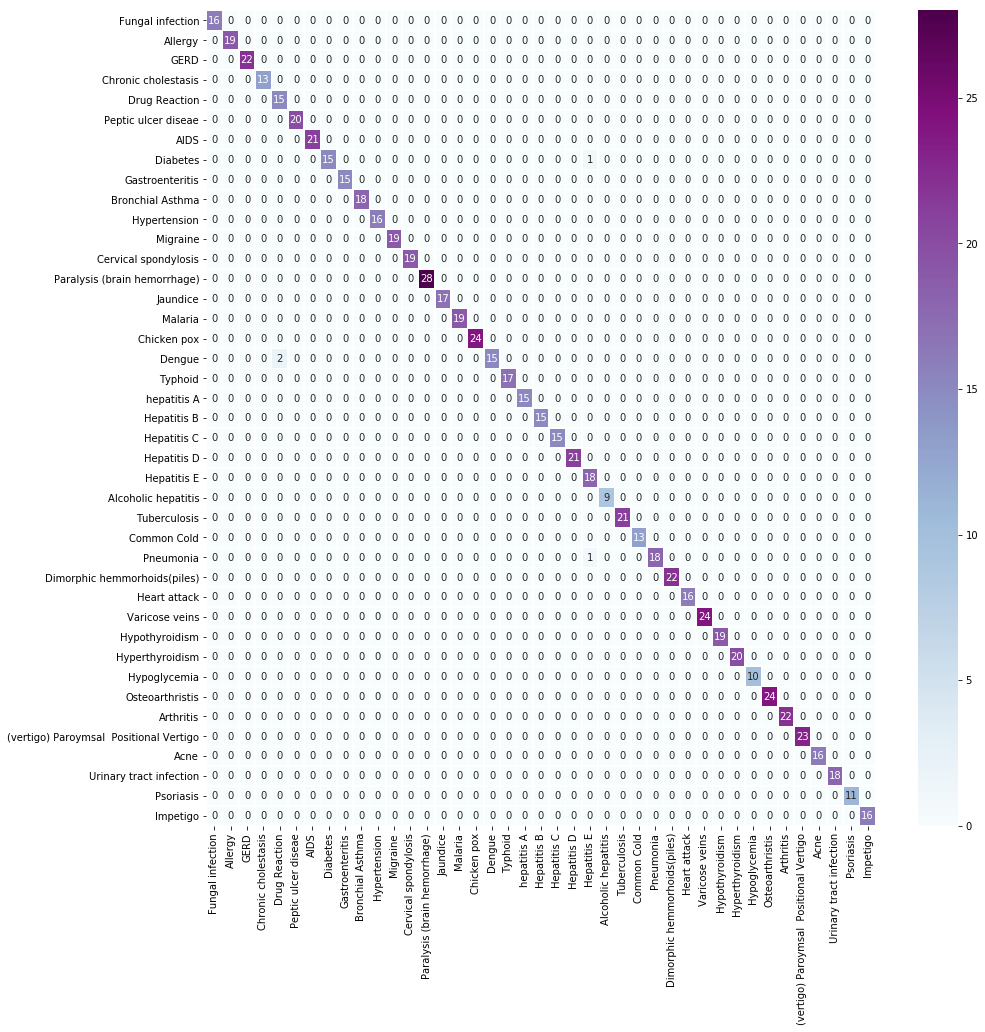

In [38]:
matrix = confusion_matrix(y_test, pred)
df_matrix = pd.DataFrame(matrix, index=df_new['Disease'].unique(), columns=df_new['Disease'].unique())
print('F1-score% =', f1_score(y_test, pred, average='macro')*100, '|', 'Accuracy% =', accuracy_score(y_test, pred)*100)

#Modify figure size and color of the plot
fig, ax = plt.subplots(figsize=(15,15))         
sns.heatmap(df_matrix, annot=True, linewidths=.5, ax=ax, cmap="BuPu")

plt.savefig('Confusion Matrix.png')

In [39]:
#Cross-validate with grid search. Set cv=10 to train and test the model 10 times.

# define parameters
param_grid = {'C': [0.1, 1, 10], 'gamma': [0.1, 1, 10]}

# create SVM model
svm_model = SVC()

# create the grid search object
grid_search = GridSearchCV(svm_model, param_grid, cv=10)

# fit back to the data
grid_search.fit(x_train, y_train)

# print the results
print("The best parameters (cv=10): ", grid_search.best_params_)
print("The best score (cv=10): ", grid_search.best_score_)

The best parameters (cv=10):  {'C': 1, 'gamma': 10}
The best score (cv=10):  0.9952175992348159


## Random forest with the disease and symptom rankings

In [40]:
df_for_train = df_new.drop('Disease' , axis =1)
label = df_new["Disease"]
df_for_train.head()

,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
0,1,3,4,7,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3,4,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,4,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,3,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [41]:
x_train, x_test, y_train, y_test = train_test_split(df_for_train, label, shuffle=True, train_size = 0.70)
randomFC = RandomForestClassifier()
rnd_forest.fit(x_train, y_train)
result = rnd_forest.predict(x_test)
print(rnd_forest)
print(classification_report(y_true=y_test, y_pred=result))
print('F1-score% =', f1_score(y_test, result, average='macro')*100, '|', 'Accuracy% =', accuracy_score(y_test, result)*100)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00        25
                                   AIDS       1.00      1.00      1.00        42
                                   Acne       1.00      1.00      1.00        28
                    Alcoholic hepatitis       1.00      1.00      1.00        28
                                Allergy       0.93      1.00      0.97        42
                              Arthritis       1.00      1.00      1.00        39
           

## Store the model in pickle and and test it

In [42]:
test_newmodel=pd.DataFrame([[1,2,3,4,5,6,7,1,2,3,4,5,6,1,2,3,4]],columns=['Symptom_1', 'Symptom_2', 'Symptom_3', 'Symptom_4', 
                                                                       'Symptom_5', 'Symptom_6', 'Symptom_7', 'Symptom_8', 
                                                                       'Symptom_9', 'Symptom_10','Symptom_11', 'Symptom_12',
                                                                       'Symptom_13', 'Symptom_14', 'Symptom_15','Symptom_16', 
                                                                       'Symptom_17'])

In [43]:
x_train.columns

Index(['Symptom_1', 'Symptom_2', 'Symptom_3', 'Symptom_4', 'Symptom_5',
       'Symptom_6', 'Symptom_7', 'Symptom_8', 'Symptom_9', 'Symptom_10',
       'Symptom_11', 'Symptom_12', 'Symptom_13', 'Symptom_14', 'Symptom_15',
       'Symptom_16', 'Symptom_17'],
      dtype='object')

In [44]:
output = rnd_forest.predict(test_newmodel)

In [45]:
output[0]

'Acne'

In [46]:
filename='Model_Final.pkl'
pickle.dump(rnd_forest,open(filename,'wb'))

In [47]:
pickle_results=pickle.load(open('Model_Final.pkl','rb'))

In [48]:
model_results = pickle_results.predict(x_test)
print(classification_report(y_true=y_test, y_pred=model_results))
print('F1-score% =', f1_score(y_test, model_results, average='macro')*100, '|', 'Accuracy% =', 
      accuracy_score(y_test, model_results)*100)

                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00        25
                                   AIDS       1.00      1.00      1.00        42
                                   Acne       1.00      1.00      1.00        28
                    Alcoholic hepatitis       1.00      1.00      1.00        28
                                Allergy       0.93      1.00      0.97        42
                              Arthritis       1.00      1.00      1.00        39
                       Bronchial Asthma       1.00      1.00      1.00        40
                   Cervical spondylosis       0.92      1.00      0.96        22
                            Chicken pox       1.00      1.00      1.00        37
                    Chronic cholestasis       1.00      1.00      1.00        31
                            Common Cold       1.00      1.00      1.00        30
                           